# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo stop the numbers to vary from time to time
# Todo add a pipeline to scale params
# Todo choose the best params and cnn architecture
# Todo implement augmentation
# Todo try to get a pretrained cnn
# Todo early stop for the best model

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
_seed= 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(_seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(_seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(_seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(_seed)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 3
args.model_name = 'deep-learning-keras-model.hdf5'
args.seed=_seed

args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()

args.run_baseline = True
args.run_early_stop = True
args.run_grid_search = True
args.run_kfold_validation = True

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [5]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [8]:
def draw_digit(pixels_2d, label=None, size_inches=None):
    fig, ax = plt.subplots()
    if label is not None:
        ax.set_title(label)
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    imgplot = ax.imshow(pixels_2d)

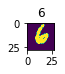

In [9]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_digit(pixels_2d, label, (0.5, 0.5))

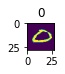

In [10]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_digit(pixels_2d, label, (0.5, 0.5))

## 2. Training of basic models

In [11]:
import sklearn.utils.multiclass

X = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
y = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_sparse = args.labels.to_numpy()
x = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y_sparse.shape: %s', repr(y_sparse.shape))
log.info('y_sparse: %s', repr(y_sparse))
log.info('y_sparse[0]: %s', y_sparse[0])
log.info('type of target y_sparse: %s', repr(sklearn.utils.multiclass.type_of_target(y_sparse)))

2020-09-17 21:46:42,283 : INFO : X.shape: (42000, 28, 28, 1)
2020-09-17 21:46:42,284 : INFO : X[0][14][14]: [254]
2020-09-17 21:46:42,284 : INFO : y.shape: (42000, 10)
2020-09-17 21:46:42,285 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2020-09-17 21:46:42,289 : INFO : type of target y: 'multilabel-indicator'
2020-09-17 21:46:42,290 : INFO : y_sparse.shape: (42000,)
2020-09-17 21:46:42,291 : INFO : y_sparse: array([1, 0, 1, ..., 7, 6, 9])
2020-09-17 21:46:42,291 : INFO : y_sparse[0]: 1
2020-09-17 21:46:42,293 : INFO : type of target y_sparse: 'multiclass'


In [12]:
def csv_sparse_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions_sparse) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_sparse = np.argmax(predictions, axis=1)
    csv_sparse_predictions(predictions_sparse, filename)

In [13]:
def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

In [14]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

def cross_val_score_sklearn(sklearn_model, X, y, scoring='accuracy', n_splits=args.n_splits, n_jobs=args.n_jobs, fit_params=None):
    cvs = cross_val_score(sklearn_model, X, y, cv=n_splits, n_jobs=n_jobs, fit_params=fit_params)
    log.info('CV mean accuracy: %0.5f. std: %0.5f', cvs.mean(), cvs.std())
    return cvs
    
def cross_val_score_keras(keras_model_builder, X, y, scoring='accuracy', n_splits=args.n_splits, n_jobs=args.n_jobs, fit_params={'epochs': args.epochs}):
    keras_classifier = KerasClassifier(keras_model_builder)
    return cross_val_score_sklearn(keras_classifier, X, y, scoring=scoring, n_splits=n_splits, n_jobs=n_jobs, fit_params=fit_params)

In [15]:
from keras import models

def build_model(layers_list, optimizer='rmsprop',
                loss='sparse_categorical_crossentropy', metrics_tuple=('accuracy')):
    model = models.Sequential(layers_list)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics_tuple])
    log.info(model.summary())
    return model

In [16]:
basic_model = None
basic_predictions = None

### 2.1 Baseline

In [17]:
from keras import layers 

def build_baseline_model_sparse():
    layers_list = [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
    return build_model(layers_list=layers_list)

2020-09-17 21:46:42,423 : INFO : None


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

2020-09-17 21:47:39,331 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


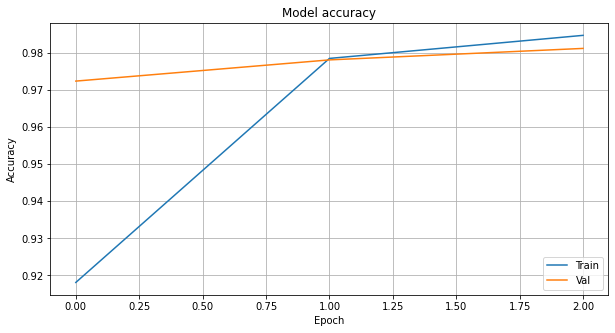

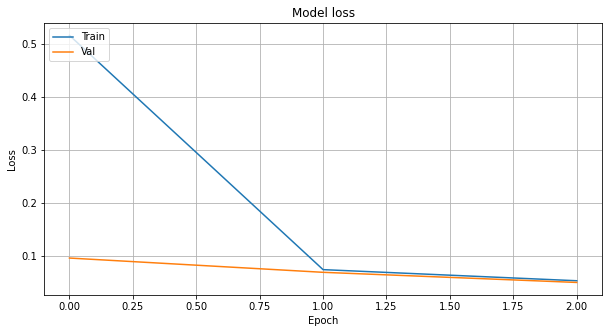

2020-09-17 21:47:43,279 : INFO : Saved file: ../predictions/cnn_baseline_predictions.csv
2020-09-17 21:47:43,475 : INFO : None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

2020-09-17 21:48:37,081 : INFO : None


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

2020-09-17 21:49:31,232 : INFO : None


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

2020-09-17 21:50:25,346 : INFO : None



Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1050/1050 [==============================] - 17s 17ms/step - loss: 0.4113 - accuracy: 0.9260
Epoch 2/3
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0844 - accuracy: 0.9775
Epoch 3/3
263/263 [==============================] - 1s 5ms/step - loss: 0.0918 - accuracy: 0.9796


2020-09-17 21:51:19,379 : INFO : None


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

2020-09-17 21:52:11,965 : INFO : CV mean accuracy: 0.97921. std: 0.00128


CPU times: user 6min 4s, sys: 1min 38s, total: 7min 42s
Wall time: 5min 29s


In [18]:
%%time

def baseline():
    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1)
    plot_history(history)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_baseline_predictions.csv')
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse)
    return model, predictions
    
if args.run_baseline:
    baseline()

### 2.2 Early stop and reduction of learning rate

2020-09-17 21:52:12,036 : INFO : None


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

2020-09-17 21:53:07,270 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


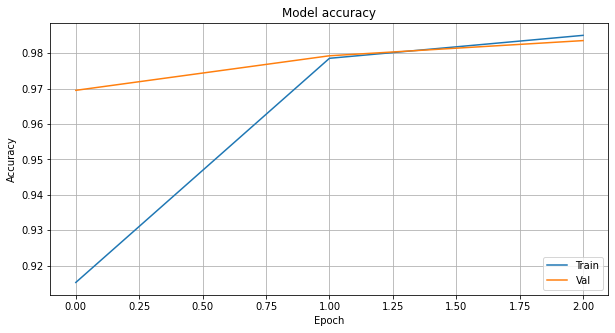

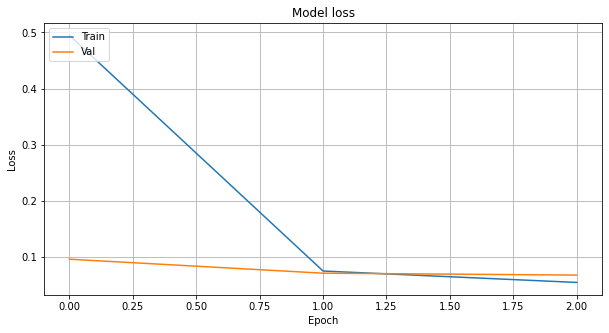

2020-09-17 21:53:11,163 : INFO : Saved file: ../predictions/cnn_early_stop_predictions.csv
2020-09-17 21:53:11,352 : INFO : None


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

2020-09-17 21:53:59,369 : INFO : None


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

2020-09-17 21:54:46,580 : INFO : None



Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
471/473 [============================>.] - ETA: 0s - loss: 0.6066 - accuracy: 0.9085
Epoch 00001: val_accuracy did not improve from 0.98512
473/473 [==============================] - 14s 31ms/step - loss: 0.6053 - accuracy: 0.9086 - val_loss: 0.1012 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9768
Epoch 00002: val_accuracy did not improve from 0.98512
473/473 [==============================] - 15s 32ms/step - loss: 0.0809 - accuracy: 0.9768 - val_loss: 0.0747 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 3/3
473/473 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9842
Epoch 00003: val_accuracy did not improve from 0.98512
263/263 [==============================] - 1s 4ms/step - loss: 0.0862 - accuracy: 0.9802: 0s -


2020-09-17 21:55:33,810 : INFO : None


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_10 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

2020-09-17 21:56:19,787 : INFO : None



Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
471/473 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.9013
Epoch 00001: val_accuracy did not improve from 0.98512
473/473 [==============================] - 14s 30ms/step - loss: 0.6677 - accuracy: 0.9014 - val_loss: 0.1194 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9749
Epoch 00002: val_accuracy did not improve from 0.98512
473/473 [==============================] - 15s 33ms/step - loss: 0.0890 - accuracy: 0.9749 - val_loss: 0.0599 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/3
471/473 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9831
Epoch 00003: val_accuracy did not improve from 0.98512
263/263 [==============================] - 1s 4ms/step - loss: 0.0774 - accuracy: 0.9785


2020-09-17 21:57:06,748 : INFO : CV mean accuracy: 0.98133. std: 0.00180


CPU times: user 5min 19s, sys: 1min 21s, total: 6min 41s
Wall time: 4min 54s


In [19]:
%%time

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def early_stop(monitor='val_loss'):
    # val_loss
    # val_accuracy
    early_stopping = EarlyStopping(monitor=monitor, patience=10, mode='auto', verbose=1)
    model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=1)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='auto')

    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

    plot_history(history)
    model.load_weights(args.model_name)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_early_stop_predictions.csv')
    
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse, n_jobs=1, fit_params={'validation_split': args.val_fraction, 'epochs': args.epochs, 'batch_size': 64, 'callbacks': [early_stopping, model_checkpoint, reduce_lr_on_plateau]})
    return model, predictions

if args.run_early_stop:
    basic_model, basic_predictions = early_stop(monitor='val_accuracy')

### 2.3 Basic grid search to choose the best architecture

In [20]:
%%time 

# Todo check metrics for keras and grid search

from keras import layers 
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def basic_grid_search_find_best_params():
    layers_candidates = {
        1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

        2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')],

        3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

        4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],
    }
    
    def _build_model_grid_search(layers_candidates_key=1):
        return build_model(layers_candidates[layers_candidates_key])
    
    keras_classifier = KerasClassifier(_build_model_grid_search, 
                                       layers_candidates_key=1)
    # scoring='neg_log_loss', 'accuracy'
    # refit=False to avoid info leak to the future kfold validation
    gcv = GridSearchCV(keras_classifier,
                         param_grid={'epochs': [1, 2, 3, 4, 5, 10], 
                                     'layers_candidates_key': list(layers_candidates.keys())},
                         refit=False,
                         cv=args.n_splits,
                         scoring='neg_log_loss',
                         n_jobs=args.n_jobs,
                         verbose=2)
    gcv.fit(X, y_sparse)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    return gcv, layers_candidates[gcv.best_params_['layers_candidates_key']]

def basic_grid_search_cv(best_grid_search_model, gcv, initial_weights):
    skf = StratifiedKFold(n_splits=args.n_splits, shuffle=True, random_state=args.seed)
    val_accuracies = np.array([])
    for train_index, val_index in skf.split(X, y_sparse):
        # Clearing the NN.
        best_grid_search_model.set_weights(initial_weights)
        history = best_grid_search_model.fit(X[train_index], y_sparse[train_index], validation_data=(X[val_index], y_sparse[val_index]), epochs=gcv.best_params_['epochs'], batch_size=64, verbose=1)
        scores = best_grid_search_model.evaluate(X[val_index], y_sparse[val_index], verbose=0)
        log.info('Iteration validation score: %s', repr(scores))
        val_accuracies = np.append(val_accuracies, scores[1])
    log.info('CV accuracy: %0.5f, std: ±%0.5f', np.mean(val_accuracies), np.std(val_accuracies))
    
def basic_grid_search():
    gcv, layers_list = basic_grid_search_find_best_params()
    best_grid_search_model = build_model(layers_list)
    # saving initial weights to avoid info leak to cross val stage
    # keras doesn't reset weights, so cross validation starts with the weights that were used on the prev stage 
    # -> they are already adapted for the current validation fold
    initial_weights = best_grid_search_model.get_weights()
    if args.run_kfold_validation:
        basic_grid_search_cv(best_grid_search_model, gcv, initial_weights)
    best_grid_search_model.set_weights(initial_weights)
    history = best_grid_search_model.fit(X, y_sparse, epochs=gcv.best_params_['epochs'], batch_size=64, verbose=1)
    predictions = best_grid_search_model.predict(x)
    csv_predictions(predictions, 'cnn_basic_grid_search.csv')
    return best_grid_search_model, predictions

if args.run_grid_search:
    basic_grid_search()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] epochs=1, layers_candidates_key=1 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
2020-09-17 21:57:06,965 : INFO : None


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)              

2020-09-17 21:57:25,047 : WARNING : From /Users/mkhokhlush/github/digit-recongizer/.venv/lib/python3.7/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py:264: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s
2020-09-17 21:57:26,298 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=1, total=  19.3s
[CV] epochs=1, layers_candidates_key=1 ...............................
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 21:57:45,698 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=1, total=  19.4s
[CV] epochs=1, layers_candidates_key=1 ...............................
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 21:58:05,206 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=1, total=  19.5s
[CV] epochs=1, layers_candidates_key=1 ...............................
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 21:58:24,843 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=1, total=  19.6s
[CV] epochs=1, layers_candidates_key=1 ...............................
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 21:58:44,323 : INFO : None



Trainable params: 241,546
Non-trainable params: 0
_________________________________________________________________
1050/1050 [==============================] - 20s 19ms/step - loss: 0.3083 - accuracy: 0.9421


2020-09-17 21:59:06,479 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=2, total=  22.2s
[CV] epochs=1, layers_candidates_key=2 ...............................
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 21:59:27,442 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=2, total=  21.0s
[CV] epochs=1, layers_candidates_key=2 ...............................
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 21:59:47,332 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=2, total=  19.9s
[CV] epochs=1, layers_candidates_key=2 ...............................
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:00:07,117 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=2, total=  19.8s
[CV] epochs=1, layers_candidates_key=2 ...............................
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:00:26,371 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=2, total=  19.2s
[CV] epochs=1, layers_candidates_key=3 ...............................
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:00:42,988 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=3, total=  16.6s
[CV] epochs=1, layers_candidates_key=3 ...............................
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:00:59,779 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=3, total=  16.8s
[CV] epochs=1, layers_candidates_key=3 ...............................
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:01:16,694 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=3, total=  16.9s
[CV] epochs=1, layers_candidates_key=3 ...............................
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:01:33,278 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=3, total=  16.6s
[CV] epochs=1, layers_candidates_key=3 ...............................
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:01:49,889 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=3, total=  16.6s
[CV] epochs=1, layers_candidates_key=4 ...............................
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
1050/1050 [==============================] - 11s 11ms/step - loss: 1.6671 - accuracy: 0.8628


2020-09-17 22:02:02,240 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=4, total=  12.4s
[CV] epochs=1, layers_candidates_key=4 ...............................
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
1050/1050 [==============================] - 11s 11ms/step - loss: 0.1257 - accuracy: 0.9665


2020-09-17 22:02:14,614 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=4, total=  12.4s
[CV] epochs=1, layers_candidates_key=4 ...............................
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
1050/1050 [==============================] - 11s 10ms/step - loss: 0.0855 - accuracy: 0.9774


2020-09-17 22:02:26,901 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=4, total=  12.3s
[CV] epochs=1, layers_candidates_key=4 ...............................
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0666 - accuracy: 0.9830


2020-09-17 22:02:39,296 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=4, total=  12.4s
[CV] epochs=1, layers_candidates_key=4 ...............................
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0553 - accuracy: 0.9872


2020-09-17 22:02:51,914 : INFO : None


[CV] ................ epochs=1, layers_candidates_key=4, total=  12.6s
[CV] epochs=2, layers_candidates_key=1 ...............................
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:03:28,727 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=1, total=  36.8s
[CV] epochs=2, layers_candidates_key=1 ...............................
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:04:05,624 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=1, total=  36.9s
[CV] epochs=2, layers_candidates_key=1 ...............................
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:04:41,755 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=1, total=  36.1s
[CV] epochs=2, layers_candidates_key=1 ...............................
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:05:18,345 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=1, total=  36.6s
[CV] epochs=2, layers_candidates_key=1 ...............................
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:05:55,058 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=1, total=  36.7s
[CV] epochs=2, layers_candidates_key=2 ...............................
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:06:32,915 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=2, total=  37.8s
[CV] epochs=2, layers_candidates_key=2 ...............................
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:07:10,261 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=2, total=  37.3s
[CV] epochs=2, layers_candidates_key=2 ...............................
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:07:47,816 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=2, total=  37.6s
[CV] epochs=2, layers_candidates_key=2 ...............................
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:08:25,504 : INFO : None


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)             

2020-09-17 22:09:03,049 : INFO : None


conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1050/1050 [==============================] - 14s 14ms/step - loss: 0.0529 - accuracy: 0.9893
Epoch 2/2
1050/1050 [============

2020-09-17 22:09:33,505 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=3, total=  30.7s
[CV] epochs=2, layers_candidates_key=3 ...............................
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:10:04,624 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=3, total=  31.1s
[CV] epochs=2, layers_candidates_key=3 ...............................
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:10:36,187 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=3, total=  31.6s
[CV] epochs=2, layers_candidates_key=3 ...............................
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:11:08,174 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=3, total=  32.0s
[CV] epochs=2, layers_candidates_key=3 ...............................
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:11:39,498 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=3, total=  31.3s
[CV] epochs=2, layers_candidates_key=4 ...............................
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1050/1050 [==============================] - 12s 11ms/step - loss: 0.0480 - accuracy: 0.9

2020-09-17 22:12:04,805 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=4, total=  25.3s
[CV] epochs=2, layers_candidates_key=4 ...............................
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1050/1050 [==============================] - 12s 12ms/step - loss: 0.0354 - accuracy: 0.9

2020-09-17 22:12:30,909 : INFO : None


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1050/1050 [==============================] - 13s 12ms/step - loss: 0.0322 - accuracy: 0.9948
Epoch 2/2
1050/1050 [==============================] - 12s 11ms/step - loss: 0.0166 - accuracy: 0.9973
[CV] ................ epochs=2, lay

2020-09-17 22:12:56,777 : INFO : None


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1050/1050 [==============================] - 13s 12ms/step - loss: 0.0218 - accuracy: 0.9965
Epoch 2/2
1050/1050 [==============================] - 14s 14ms/step - loss: 0.0171 - accuracy: 0.9974
[CV] ................ epochs=2, lay

2020-09-17 22:13:25,545 : INFO : None


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1050/1050 [==============================] - 12s 12ms/step - loss: 0.0119 - accuracy: 0.9981
Epoch 2/2
1050/1050 [==============================] - 13s 12ms/step - loss: 0.0103 - accuracy: 0.9983


2020-09-17 22:13:52,114 : INFO : None


[CV] ................ epochs=2, layers_candidates_key=4, total=  26.6s
[CV] epochs=3, layers_candidates_key=1 ...............................
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:14:46,492 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=1, total=  54.4s
[CV] epochs=3, layers_candidates_key=1 ...............................
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:15:41,377 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=1, total=  54.9s
[CV] epochs=3, layers_candidates_key=1 ...............................
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:16:34,765 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=1, total=  53.4s
[CV] epochs=3, layers_candidates_key=1 ...............................
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:17:29,659 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=1, total=  54.9s
[CV] epochs=3, layers_candidates_key=1 ...............................
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:18:24,404 : INFO : None


Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)             

2020-09-17 22:19:22,914 : INFO : None


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)             

2020-09-17 22:20:21,450 : INFO : None


Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)             

2020-09-17 22:21:23,405 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=2, total= 1.0min
[CV] epochs=3, layers_candidates_key=2 ...............................
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:22:20,807 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=2, total=  57.4s
[CV] epochs=3, layers_candidates_key=2 ...............................
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:23:18,182 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=2, total=  57.4s
[CV] epochs=3, layers_candidates_key=3 ...............................
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:24:03,368 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=3, total=  45.2s
[CV] epochs=3, layers_candidates_key=3 ...............................
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:24:49,872 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=3, total=  46.5s
[CV] epochs=3, layers_candidates_key=3 ...............................
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:25:35,721 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=3, total=  45.8s
[CV] epochs=3, layers_candidates_key=3 ...............................
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:26:22,502 : INFO : None


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
_______________________________________________

2020-09-17 22:27:09,340 : INFO : None


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0126 - accuracy: 0.9984
Epoch 2/3
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0072 - accuracy: 0.9989
Epoch 3/3
1050/1050 [==============

2020-09-17 22:27:44,732 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=4, total=  35.5s
[CV] epochs=3, layers_candidates_key=4 ...............................
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0068 - accuracy: 0.9

2020-09-17 22:28:20,167 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=4, total=  35.4s
[CV] epochs=3, layers_candidates_key=4 ...............................
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0074 - accuracy: 0.9

2020-09-17 22:28:55,517 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=4, total=  35.3s
[CV] epochs=3, layers_candidates_key=4 ...............................
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0054 - accuracy: 0.9

2020-09-17 22:29:31,077 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=4, total=  35.6s
[CV] epochs=3, layers_candidates_key=4 ...............................
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0055 - accuracy: 0.9

2020-09-17 22:30:06,684 : INFO : None


[CV] ................ epochs=3, layers_candidates_key=4, total=  35.6s
[CV] epochs=4, layers_candidates_key=1 ...............................
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:31:18,211 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=1, total= 1.2min
[CV] epochs=4, layers_candidates_key=1 ...............................
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:32:30,332 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=1, total= 1.2min
[CV] epochs=4, layers_candidates_key=1 ...............................
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:33:41,833 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=1, total= 1.2min
[CV] epochs=4, layers_candidates_key=1 ...............................
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:34:52,931 : INFO : None


Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)              

2020-09-17 22:36:03,185 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=1, total= 1.2min
[CV] epochs=4, layers_candidates_key=2 ...............................
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:37:22,453 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=2, total= 1.3min
[CV] epochs=4, layers_candidates_key=2 ...............................
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:38:36,365 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=2, total= 1.2min
[CV] epochs=4, layers_candidates_key=2 ...............................
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:39:50,440 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=2, total= 1.2min
[CV] epochs=4, layers_candidates_key=2 ...............................
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:41:04,532 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=2, total= 1.2min
[CV] epochs=4, layers_candidates_key=2 ...............................
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 22:42:18,222 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=2, total= 1.2min
[CV] epochs=4, layers_candidates_key=3 ...............................
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:43:19,828 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=3, total= 1.0min
[CV] epochs=4, layers_candidates_key=3 ...............................
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:44:21,524 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=3, total= 1.0min
[CV] epochs=4, layers_candidates_key=3 ...............................
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:45:23,819 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=3, total= 1.0min
[CV] epochs=4, layers_candidates_key=3 ...............................
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:46:24,272 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=3, total= 1.0min
[CV] epochs=4, layers_candidates_key=3 ...............................
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)    

2020-09-17 22:47:25,412 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=3, total= 1.0min
[CV] epochs=4, layers_candidates_key=4 ...............................
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0055 - accuracy: 0.9

2020-09-17 22:48:11,102 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=4, total=  45.7s
[CV] epochs=4, layers_candidates_key=4 ...............................
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0041 - accuracy: 0.9

2020-09-17 22:48:56,715 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=4, total=  45.6s
[CV] epochs=4, layers_candidates_key=4 ...............................
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0012 - accuracy: 0.9

2020-09-17 22:49:42,258 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=4, total=  45.5s
[CV] epochs=4, layers_candidates_key=4 ...............................
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0020 - accuracy: 0.9

2020-09-17 22:50:28,111 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=4, total=  45.9s
[CV] epochs=4, layers_candidates_key=4 ...............................
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1050/1050 [==============================] - 11s 11ms/step - loss: 7.8259e-04 - accuracy:

2020-09-17 22:51:13,957 : INFO : None


[CV] ................ epochs=4, layers_candidates_key=4, total=  45.8s
[CV] epochs=5, layers_candidates_key=1 ...............................
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:52:43,002 : INFO : None


Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)              

2020-09-17 22:54:10,052 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=1, total= 1.5min
[CV] epochs=5, layers_candidates_key=1 ...............................
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:55:38,735 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=1, total= 1.5min
[CV] epochs=5, layers_candidates_key=1 ...............................
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:57:06,896 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=1, total= 1.5min
[CV] epochs=5, layers_candidates_key=1 ...............................
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)   

2020-09-17 22:58:35,363 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=1, total= 1.5min
[CV] epochs=5, layers_candidates_key=2 ...............................
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 23:00:07,114 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=2, total= 1.5min
[CV] epochs=5, layers_candidates_key=2 ...............................
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 23:01:39,512 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=2, total= 1.5min
[CV] epochs=5, layers_candidates_key=2 ...............................
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)  

2020-09-17 23:03:11,677 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=2, total= 1.5min
[CV] epochs=5, layers_candidates_key=2 ...............................
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-17 23:04:55,137 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=2, total= 1.7min
[CV] epochs=5, layers_candidates_key=2 ...............................
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-17 23:06:27,355 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=2, total= 1.5min
[CV] epochs=5, layers_candidates_key=3 ...............................
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-17 23:07:42,096 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=3, total= 1.2min
[CV] epochs=5, layers_candidates_key=3 ...............................
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-17 23:08:58,191 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=3, total= 1.3min
[CV] epochs=5, layers_candidates_key=3 ...............................
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-17 23:10:14,274 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=3, total= 1.3min
[CV] epochs=5, layers_candidates_key=3 ...............................
Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-17 23:45:47,536 : INFO : None


Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
______________________________________________

2020-09-18 03:48:35,127 : INFO : None


Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1050/1050 [==============================] - 7233s 7s/step - loss: 1.8876e-04 - accuracy: 0.9999
Epoch 2/5
1050/1050 [==============================] - 25s 24ms/step - loss: 2.5642e-04 - accuracy: 1.0000
Epoch 3/5
1050/1050 [=====

2020-09-18 08:00:09,835 : INFO : None


Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1050/1050 [==============================] - 12s 11ms/step - loss: 4.4470e-04 - accuracy: 0.9999
Epoch 2/5
1050/1050 [==============================] - 11s 11ms/step - loss: 2.1344e-04 - accuracy: 1.0000
Epoch 3/5
1050/1050 [=====

2020-09-18 08:01:08,349 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=4, total=  58.6s
[CV] epochs=5, layers_candidates_key=4 ...............................
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1050/1050 [==============================] - 11s 11ms/step - loss: 9.1330e-05 - accuracy

2020-09-18 08:02:05,780 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=4, total=  57.4s
[CV] epochs=5, layers_candidates_key=4 ...............................
Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1050/1050 [==============================] - 11s 11ms/step - loss: 6.7319e-05 - accuracy

2020-09-18 08:03:03,584 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=4, total=  57.8s
[CV] epochs=5, layers_candidates_key=4 ...............................
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0036 - accuracy: 0.

2020-09-18 08:04:00,622 : INFO : None


[CV] ................ epochs=5, layers_candidates_key=4, total=  57.0s
[CV] epochs=10, layers_candidates_key=1 ..............................
Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)  

2020-09-18 08:06:56,122 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=1, total= 2.9min
[CV] epochs=10, layers_candidates_key=1 ..............................
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)  

2020-09-18 08:09:54,775 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=1, total= 3.0min
[CV] epochs=10, layers_candidates_key=1 ..............................
Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)  

2020-09-18 08:12:53,545 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=1, total= 3.0min
[CV] epochs=10, layers_candidates_key=1 ..............................
Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)  

2020-09-18 08:15:50,754 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=1, total= 3.0min
[CV] epochs=10, layers_candidates_key=1 ..............................
Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)  

2020-09-18 08:18:47,761 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=1, total= 3.0min
[CV] epochs=10, layers_candidates_key=2 ..............................
Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-18 08:21:49,722 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=2, total= 3.0min
[CV] epochs=10, layers_candidates_key=2 ..............................
Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-18 08:25:08,928 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=2, total= 3.3min
[CV] epochs=10, layers_candidates_key=2 ..............................
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-18 08:28:16,855 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=2, total= 3.1min
[CV] epochs=10, layers_candidates_key=2 ..............................
Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-18 08:31:18,372 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=2, total= 3.0min
[CV] epochs=10, layers_candidates_key=2 ..............................
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152) 

2020-09-18 08:34:20,588 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=2, total= 3.0min
[CV] epochs=10, layers_candidates_key=3 ..............................
Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-18 08:36:53,494 : INFO : None


Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
______________________________________________

2020-09-18 08:39:28,277 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=3, total= 2.6min
[CV] epochs=10, layers_candidates_key=3 ..............................
Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-18 08:42:00,260 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=3, total= 2.5min
[CV] epochs=10, layers_candidates_key=3 ..............................
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-18 08:44:34,247 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=3, total= 2.6min
[CV] epochs=10, layers_candidates_key=3 ..............................
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

2020-09-18 08:47:06,020 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=3, total= 2.5min
[CV] epochs=10, layers_candidates_key=4 ..............................
Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1050/1050 [==============================] - 11s 11ms/step - loss: 5.1967e-05 - accurac

2020-09-18 08:48:59,058 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=4, total= 1.9min
[CV] epochs=10, layers_candidates_key=4 ..............................
Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1050/1050 [==============================] - 11s 11ms/step - loss: 6.9872e-05 - accurac

2020-09-18 08:50:52,650 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=4, total= 1.9min
[CV] epochs=10, layers_candidates_key=4 ..............................
Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1050/1050 [==============================] - 11s 11ms/step - loss: 8.1617e-05 - accurac

2020-09-18 08:52:44,690 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=4, total= 1.9min
[CV] epochs=10, layers_candidates_key=4 ..............................
Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0000e+00 - accurac

2020-09-18 08:54:37,698 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=4, total= 1.9min
[CV] epochs=10, layers_candidates_key=4 ..............................
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1050/1050 [==============================] - 11s 11ms/step - loss: 0.0000e+00 - accurac

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 659.4min finished
2020-09-18 08:56:30,336 : INFO : Best params: {'epochs': 10, 'layers_candidates_key': 4}
2020-09-18 08:56:30,337 : INFO : Best CV score: -0.0001120362154081628
2020-09-18 08:56:30,337 : INFO : Best std: 0.0002240724308163256
2020-09-18 08:56:30,362 : INFO : None


[CV] ............... epochs=10, layers_candidates_key=4, total= 1.9min
Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_15 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1384512   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,385,482
Trainable params: 1,385,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
525/525

2020-09-18 08:57:57,583 : INFO : Iteration validation score: [0.0, 1.0]


Epoch 1/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accura

2020-09-18 08:59:24,066 : INFO : Iteration validation score: [0.0, 1.0]


Epoch 1/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accura

2020-09-18 09:00:50,529 : INFO : Iteration validation score: [0.0, 1.0]


Epoch 1/10
525/525 [==============================] - 9s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
525/525 [==============================] - 9s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accura

2020-09-18 09:02:16,000 : INFO : Iteration validation score: [0.0, 1.0]


Epoch 1/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
525/525 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - accura

2020-09-18 09:03:41,049 : INFO : Iteration validation score: [0.0, 1.0]
2020-09-18 09:03:41,050 : INFO : CV accuracy: 1.00000, std: ±0.00000


Epoch 1/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
657/657 [=========================

2020-09-18 09:05:20,681 : INFO : Saved file: ../predictions/cnn_basic_grid_search.csv


CPU times: user 3h 11min 47s, sys: 34min 45s, total: 3h 46min 32s
Wall time: 11h 8min 13s


### 2.4 Error analysis

2020-09-18 09:05:20,706 : INFO : (28000, 10)
2020-09-18 09:05:20,716 : INFO : The most likely numbers for the less confident prediction: [5 7 9], probabilities: [0.1826732  0.22266634 0.2502594 ]
2020-09-18 09:05:20,718 : INFO : Most confused indices: [11695 23271 18753  9840 10717 21368 25423  5101 18055   683]
2020-09-18 09:05:20,719 : INFO : The most likely numbers for the less confident predictions: 
[[2 8 9]
 [5 7 9]
 [6 8 0]
 [3 9 5]
 [4 7 9]
 [2 8 3]
 [9 7 3]
 [8 9 4]
 [3 2 8]
 [1 2 9]], 
probabilities: 
[[0.16 0.4  0.3 ]
 [0.18 0.22 0.25]
 [0.27 0.36 0.36]
 [0.29 0.34 0.37]
 [0.2  0.38 0.4 ]
 [0.23 0.33 0.33]
 [0.17 0.27 0.38]
 [0.2  0.27 0.37]
 [0.13 0.3  0.38]
 [0.21 0.26 0.4 ]]


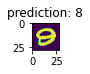

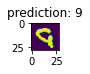

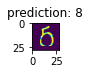

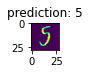

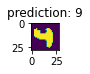

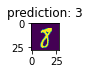

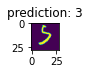

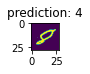

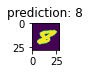

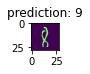

In [21]:
# analysis of the most confusing predicitons
def analyse_confusing_predictions(predictions=basic_predictions, n_confused=10, test_data=None):
    log.info(predictions.shape)
    probabilities_sparse = np.max(predictions, axis=1)
    min_prob = np.min(probabilities_sparse)
    min_index = np.argmin(probabilities_sparse, axis=0)
    log.info('The most likely numbers for the less confident prediction: %s, probabilities: %s', 
             np.argpartition(predictions[min_index], -3)[-3:], 
             predictions[min_index][np.argpartition(predictions[min_index], -3)[-3:]])
    
    most_confused_predictions_indices = np.argpartition(probabilities_sparse, n_confused)[:n_confused]
    log.info('Most confused indices: %s', most_confused_predictions_indices)
    most_confused_probabilities = predictions[most_confused_predictions_indices]
    likely_numbers_most_confused_probabilities = np.argpartition(most_confused_probabilities, -3, axis=1)[:, -3:]

    probabilities_likely_numbers_most_confused_probabilities = np.empty(likely_numbers_most_confused_probabilities.shape)
    for i, row in enumerate(most_confused_probabilities):
        probabilities_likely_numbers_most_confused_probabilities[i] = row[likely_numbers_most_confused_probabilities[i]]

    log.info('The most likely numbers for the less confident predictions: \n%s, \nprobabilities: \n%s', 
            likely_numbers_most_confused_probabilities,
            np.around(probabilities_likely_numbers_most_confused_probabilities, decimals=2))

    if test_data is not None:
        for most_confusing_predictions_index in most_confused_predictions_indices:
            draw_digit(test_data.iloc[most_confusing_predictions_index, :].to_numpy().reshape(28, 28), label="prediction: " + str(np.argmax(basic_predictions[most_confusing_predictions_index])), size_inches=(0.5, 0.5))

analyse_confusing_predictions(predictions=basic_predictions, test_data=args.raw_test)

1
2
3
4
5
(140, 140)
1
(28, 28)
1
2
3
4
5
(140, 140)
1
2
3
4
5
(140, 140)


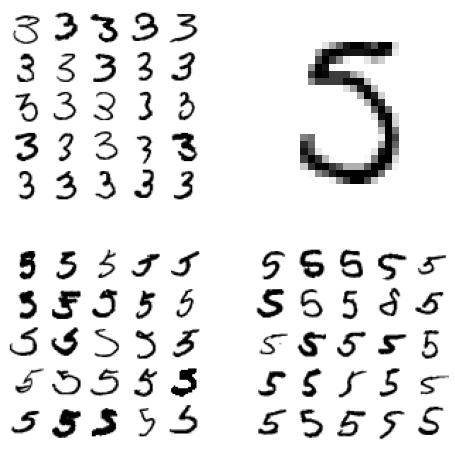

In [22]:
import matplotlib

# the ml hands-on book implementation
def error_analysis_plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
#     print(images[1])
#     print(len(images))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
#         print(len(rimages))
#         print(rimages)
        row_images.append(np.concatenate(rimages, axis=1))
        print(len(row_images))
#     print(row_images)
    image = np.concatenate(row_images, axis=0)
    print(image.shape)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
predictions_train_sparse = np.argmax(basic_model.predict(X), axis=1)
X_33 = X[(y_sparse == 3) & (predictions_train_sparse == 3)]
X_35 = X[(y_sparse == 3) & (predictions_train_sparse == 5)]
X_53 = X[(y_sparse == 5) & (predictions_train_sparse == 3)]
X_55 = X[(y_sparse == 5) & (predictions_train_sparse == 5)]
plt.figure(figsize=(8, 8))
plt.subplot(221); error_analysis_plot_digits(X_33[:25], images_per_row=5)
plt.subplot(222); error_analysis_plot_digits(X_35[:25], images_per_row=5)
plt.subplot(223); error_analysis_plot_digits(X_53[:25], images_per_row=5)
plt.subplot(224); error_analysis_plot_digits(X_55[:25], images_per_row=5)

plt.show()

(25, 28, 28)
(5, 28, 28)
(25, 28, 28)
(25, 28, 28)


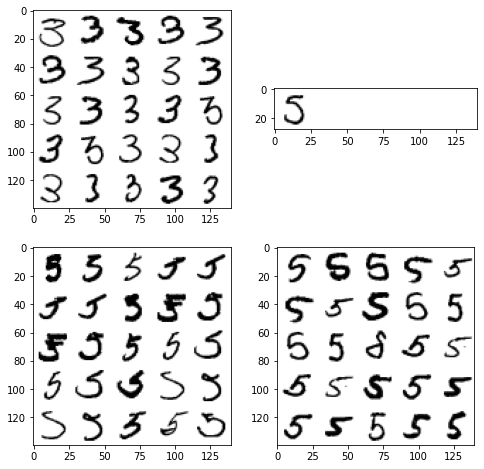

In [23]:
import math
import matplotlib
# make a large image (140x140) consisted of small images (28x28) by vstacking rows
# * * -> **
#        **
# * *    
def error_analysis_draw_digits(numbers, images_per_row, title='', **options):
    image_resolution = 28
    images_per_col = math.ceil(len(numbers) / images_per_row)
    instances = np.copy(numbers).reshape(numbers.shape[0], image_resolution, image_resolution)
    zero_instances_num = images_per_row * images_per_col - len(instances)
    instances = np.append(instances, np.zeros((zero_instances_num, image_resolution, image_resolution), dtype='int'), axis=0)
    print(instances.shape)
    
    large_image_rows = []
    for r in range(images_per_col):
        for rs in range(image_resolution): 
            large_image_row = np.empty([0, 0], dtype='int')
            for c in range(images_per_row):
                large_image_row = np.append(large_image_row, instances[r * 3 + c][rs])
            large_image_rows.append(large_image_row)
    
    large_image = np.vstack(large_image_rows)
    plt.imshow(large_image, cmap = matplotlib.cm.binary, **options)
    

predictions_train_sparse = np.argmax(basic_model.predict(X), axis=1)
X_33 = X[(y_sparse == 3) & (predictions_train_sparse == 3)]
X_35 = X[(y_sparse == 3) & (predictions_train_sparse == 5)]
X_53 = X[(y_sparse == 5) & (predictions_train_sparse == 3)]
X_55 = X[(y_sparse == 5) & (predictions_train_sparse == 5)]
plt.figure(figsize=(8, 8))
plt.subplot(221); 
error_analysis_draw_digits(X_33[:23], images_per_row=5, title='Answer: 3, Prediction: 3')
plt.subplot(222); 
error_analysis_draw_digits(X_35[:25], images_per_row=5, title='Answer: 3, Prediction: 5')
plt.subplot(223); 
error_analysis_draw_digits(X_53[:25], images_per_row=5, title='Answer: 5, Prediction: 3')
plt.subplot(224); 
error_analysis_draw_digits(X_55[:25], images_per_row=5, title='Answer: 5, Prediction: 5')

plt.show()

<Figure size 576x576 with 0 Axes>

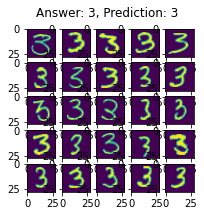

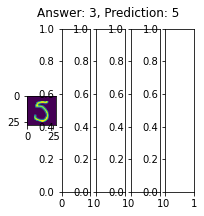

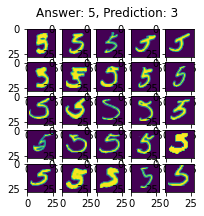

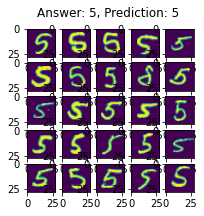

In [24]:
import math
import matplotlib
# print confusing numbers
def error_analysis_draw_digits_legacy(numbers, images_per_row, title=''):
    images_per_col = math.ceil(len(numbers) / images_per_row)
    fig, axs = plt.subplots(images_per_col, images_per_row, figsize=(3, 3))
    fig.suptitle(title)
    for row in range(images_per_col):
        for col in range(images_per_row):
            number_index = (row) * images_per_row + col
            if number_index + 1 > len(numbers):
                return
            if images_per_col > 1:
                ax = axs[row, col]
            else:
                # if numbers <= images_per_row, axs is 1-dim array
                ax = axs[col]
            imgplot = ax.imshow(numbers[number_index].reshape(28, 28))

predictions_train_sparse = np.argmax(basic_model.predict(X), axis=1)
X_33 = X[(y_sparse == 3) & (predictions_train_sparse == 3)]
X_35 = X[(y_sparse == 3) & (predictions_train_sparse == 5)]
X_53 = X[(y_sparse == 5) & (predictions_train_sparse == 3)]
X_55 = X[(y_sparse == 5) & (predictions_train_sparse == 5)]
plt.figure(figsize=(8, 8))
error_analysis_draw_digits_legacy(X_33[:25], images_per_row=5, title='Answer: 3, Prediction: 3')
error_analysis_draw_digits_legacy(X_35[:25], images_per_row=5, title='Answer: 3, Prediction: 5')
error_analysis_draw_digits_legacy(X_53[:25], images_per_row=5, title='Answer: 5, Prediction: 3')
error_analysis_draw_digits_legacy(X_55[:25], images_per_row=5, title='Answer: 5, Prediction: 5')

plt.show()

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | 50 epochs | 0.98657 | 0.98790 ±0.00069 |
| Early stop and reduction of learning rate (val_loss) | 9 epochs | 0.98932 | 0.98948 ±0.00059 |
| Early stop and reduction of learning rate (val_accuracy) | 14 epochs | 0.99003 | 0.99017 ±0.00037 |
| Basic grid search (accuracy) | 50 epochs out of 5, 15, 25, 50; layers: 1 | 0.98800 | 0.98631 ±0.00007 |
| Basic grid search (neg_log_loss) | 3 epochs out of 1, 2, 3, 5, 10; layers: 2 | 0.97989 | 0.98152 ±0.00263 |


# These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |